# Imports

In [1]:
import os, sys, time, glob, random, argparse
import wandb
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.tss_model import TinyNetwork
from xautodl.models.cell_searchs.genotypes import Structure
from ZeroShotProxy import *
from tss_utils import compute_vkdnw, plot_stats, get_stats, get_metrics, analyze_results, generate_accs, get_results_from_api, get_scores

# All

In [2]:
# scp 'tyblondr@login.rci.cvut.cz:~/PycharmProjects/VKDNW/NB201/ImageNet16*' plots_2710/

target = 'val_accs'
dataset = 'ImageNet16-120'
compute_graf = True
zero_cost_score_list = ['vkdnw', 'vkdnw_dim', 'vkdnw_chisquare']#, 'az_nas', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas']

In [3]:
run_dict = {
    'cifar10': {
        # same images
        #'nazderaze/VKDNW/n6n44keg': 1,
        #'nazderaze/VKDNW/6c1pv095': 2,
        #'nazderaze/VKDNW/45us11be': 3,
        #'nazderaze/VKDNW/rwp2qvkw': 4,
        #'nazderaze/VKDNW/6bsssh4z': 5,
        
        # different images
        #'nazderaze/VKDNW/7a8jm975' : -1 # testing (successfull)
        'nazderaze/VKDNW/cixw6r9b': 1,
        'nazderaze/VKDNW/1nikalf3': 2,
        'nazderaze/VKDNW/r5l3qg12': 3,
        'nazderaze/VKDNW/fq581h0d': 4,
        'nazderaze/VKDNW/0yfzaxra': 5,
    },
    'cifar100': {
        # same images
        #'nazderaze/VKDNW/qmq5vp3k': 1,
        #'nazderaze/VKDNW/31lrq6p7': 2,
        #'nazderaze/VKDNW/3qazc6po': 3,
        #'nazderaze/VKDNW/424twoyv': 4,
        #'nazderaze/VKDNW/783h4opf': 5,
        
        # different images
        'nazderaze/VKDNW/n2m8i53l': 1,
        'nazderaze/VKDNW/48xbnfdg': 2,
        'nazderaze/VKDNW/f0czkx5u': 3,
        'nazderaze/VKDNW/ldv3b1bh': 4,
        'nazderaze/VKDNW/qwae4nqx': 5,
    },
    'ImageNet16-120': {
        # same images
        #'nazderaze/VKDNW/ftg0tdsa': 1,
        #'nazderaze/VKDNW/vqf1ey6x': 2,
        #'nazderaze/VKDNW/v0a0m67q': 3,
        #'nazderaze/VKDNW/uiv37u18': 4,
        #'nazderaze/VKDNW/c1338vfg': 5,
        
        # different images
        'nazderaze/VKDNW/55f1omxn': 1,
        'nazderaze/VKDNW/amdcxrz7': 2,
        'nazderaze/VKDNW/sl0rjhwh': 3,
        'nazderaze/VKDNW/z2ph6iav': 4,
        'nazderaze/VKDNW/ol9rwkeo': 5,
        
        # 'nazderaze/VKDNW/hwtw58ot' entropy test
    }
}

In [4]:
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")

In [5]:
api_wandb = wandb.Api()

log = None
results = None
for run_id, seed in run_dict[dataset].items():
    
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run.rename({'arch': 'net_str'}, axis=1, inplace=True)
    
    run = pd.merge(archs, run, on='net_str', how='inner')
    if compute_graf:
        run = run.loc[run['net'].notnull(), :]  # keep only nets with features
        
    print(f'No. of archs for seed {seed} after filtering: {run.shape[0]}.')
    
    for col in run.columns:
        if col not in ['net_str', 'net']:
            run[col] = run[col].astype(float)
    
    if 'jacov' in run.columns:        
        run['jacov'] = run['jacov'].fillna(run['jacov'].min()).astype(float)

    df_scores = get_scores(run.copy(), compute_graf=compute_graf, zero_cost_score_list=zero_cost_score_list)
    df_scores['dataset'] = dataset
    df_scores['seed'] = seed
    if results is None:
        results = df_scores
    else:
        results = pd.concat([results, df_scores], ignore_index=True)
print(f'Total number of records: {results.shape[0]}')

No. of archs for seed 1 after filtering: 7197.
Running vkdnw


KeyError: 'progressivity'

In [77]:
log = None
for seed in results['seed'].unique():
    
    results_temp = results.loc[results['seed'] == seed, :].copy()
    for zero_cost_rank in [p for p in results_temp.columns if '_rank' in p]:
        results_temp[[zero_cost_rank]] = results_temp[[zero_cost_rank]].apply(lambda x: x.replace(-np.inf, x[x != -np.inf].min()))
        results_temp[[zero_cost_rank]] = results_temp[[zero_cost_rank]].apply(lambda x: x.replace(-np.nan, x[x != -np.inf].min()))
        results_temp[[zero_cost_rank]] = results_temp[[zero_cost_rank]].apply(lambda x: x.replace(np.inf, x[x != np.inf].max()))
        log_temp = pd.DataFrame(get_metrics(results_temp, pred_name=zero_cost_rank, show_plot=False))
        
        if log is None:
            log = log_temp.copy()
        else:
            log = pd.concat([log, log_temp.copy()], ignore_index=True)
            
        if seed == min(results['seed'].unique()):
            plot_stats(get_stats(results_temp, 'vkdnw_dim', target, zero_cost_rank), 'vkdnw_dim', target, zero_cost_rank, f'{dataset}_{str(compute_graf)}_{zero_cost_rank}')

log = log.groupby('pred_name', as_index=False).agg(['mean', 'std']).reset_index()
log['dataset'] = dataset
log['no_seeds'] = len(results['seed'].unique())
log['archs_filtered'] = str(compute_graf)
log

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

pred_name   kendall            spearman             pearson  \
                              mean       std      mean       std      mean   
0            az_nas_rank  0.722913  0.000735  0.899911  0.000563  0.858985   
1         grad_norm_rank  0.358166  0.000568  0.488597  0.000912  0.101086   
2          gradsign_rank -0.240245  0.000536 -0.314477  0.000425  0.214410   
3             grasp_rank  0.321409  0.003612  0.460318  0.005321  0.001008   
4             jacov_rank  0.554356  0.001063  0.720426  0.000687  0.789449   
5            naswot_rank  0.578942  0.000108  0.768189  0.000139  0.798021   
6              snip_rank  0.461286  0.000273  0.619644  0.000670  0.187747   
7           synflow_rank  0.564794  0.000248  0.761186  0.000166  0.057212   
8            te_nas_rank  0.481388  0.001266  0.664920  0.001451  0.649452   
9   vkdnw_chisquare_rank  0.016806  0.003247  0.024680  0.004612 -0.460186   
10       vkdnw_comb_rank  0.732095  0.000481  0.904158  0.000248  0.844352   
11        vkdnw_dim_rank  0.594197  0.000000  0.737453  0.000000  0.543845   
12        vkdnw_exp_rank  0.692471  0.001049  0.880497  0.000778  0.778559   
13       vkdnw_prog_rank  0.711067  0.000627  0.894364  0.000407  0.786098   
14            vkdnw_rank  0.530623  0.000598  0.724152  0.000594  0.572388   
15      vkdnw_train_rank  0.688582  0.000704  0.872362  0.000556  0.800609   
16              zen_rank  0.231769  0.000120  0.299818  0.000237  0.455960   
17             zico_rank  0.600222  0.000513  0.794614  0.000497  0.641469   

               auc_roc              auc_pr  ...      gain_exp  gain_log  \
         std      mean       std      mean  ...           std      mean   
0   0.001394  0.601747  0.000069  0.675895  ...  2.939682e-03  0.705002   
1   0.006452  0.565401  0.000100  0.655672  ...  1.097186e-02  0.615374   
2   0.000113  0.492817  0.000037  0.586127  ...  8.772986e-02  0.387430   
3   0.003352  0.554953  0.000542  0.651509  ...  2.311487e-02  0.624852   
4   0.015163  0.592515  0.000037  0.664911  ...  1.307194e-02  0.661345   
5   0.000068  0.593288  0.000025  0.670777  ...  7.872189e-03  0.696276   
6   0.005290  0.581668  0.000072  0.661045  ...  2.461160e-02  0.618563   
7   0.000298  0.588841  0.000017  0.669583  ...  8.336650e-03  0.705879   
8   0.000560  0.585414  0.000088  0.664822  ...  5.847807e-03  0.675333   
9   0.000589  0.490329  0.000351  0.578990  ...  1.436350e-12  0.010000   
10  0.000425  0.601551  0.000031  0.676343  ...  2.370299e-03  0.705651   
11  0.000000  0.576300  0.000000  0.664856  ...  0.000000e+00  0.702192   
12  0.000584  0.597974  0.000068  0.674950  ...  2.526533e-03  0.707761   
13  0.000492  0.599256  0.000038  0.675669  ...  3.191484e-03  0.707945   
14  0.000820  0.578774  0.000041  0.666658  ...  4.109173e-03  0.705403   
15  0.000813  0.597855  0.000054  0.674150  ...  1.336723e-02  0.703687   
16  0.000156  0.545617  0.000019  0.629535  ...  1.155184e-03  0.618693   
17  0.000067  0.592518  0.000046  0.671929  ...  6.056961e-04  0.705531   

                   acc_top1             acc_top50             dataset  \
             std       mean        std       mean       std             
0   2.043035e-03  70.860667   0.729351  70.312520  0.051009  cifar100   
1   5.175541e-03  61.138667   1.024244  63.903907  0.127266  cifar100   
2   5.575284e-02  35.090667  15.614333  39.205440  1.762114  cifar100   
3   1.501343e-02  59.330667   5.331287  64.019493  0.471051  cifar100   
4   5.877893e-03  64.750667   1.906127  65.864747  0.389190  cifar100   
5   1.998921e-03  66.409333   1.571210  70.173373  0.026066  cifar100   
6   1.183987e-02  59.920667   5.677397  64.183893  0.097073  cifar100   
7   4.251129e-03  70.662667   2.212473  70.374253  0.051623  cifar100   
8   1.089649e-03  67.636000   1.310281  67.833400  0.280142  cifar100   
9   7.511146e-13   1.000000   0.000000   1.000000  0.000000  cifar100   
10  3.377510e-03  70.698000   0.446677  70.395133  0.087242  cifar100   
11  

vkdnw
expressivity
trainability
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=5721
cifar10-valid  FLOP=188.66 M, Params=1.317 MB, latency=22.33 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.469 & top1 = 90.65%]
cifar10        FLOP=188.66 M, Params=1.317 MB, latency=22.33 ms.
cifar10        train : [loss = 0.002 & top1 = 99.97%], test  : [loss = 0.294 & top1 = 93.98%]
cifar100       FLOP=188.67 M, Params=1.322 MB, latency=23.94 ms.
cifar100       train : [loss = 0.036 & top1 = 99.62%], valid : [loss = 1.364 & top1 = 70.05%], test : [loss = 1.363 & top1 = 70.22%]
ImageNet16-120 FLOP= 47.17 M, Params=1.324 MB, latency=20.38 ms.
ImageNet16-120 train : [loss = 1.616 & top1 = 56.53%], valid : [loss = 2.175 & top1 = 44.11%], test : [loss = 2.163 & top1 = 45.57%]
trainability: 0.7111663547863226	0.8944711751762058	0.8944

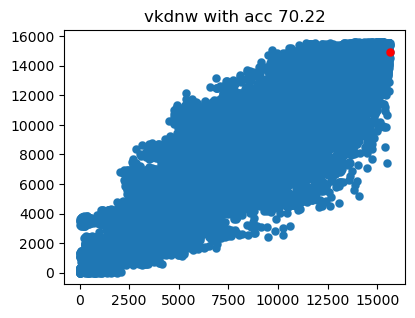

vkdnw_dim
|nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4317
cifar10-valid  FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10-valid  train : [loss = 0.072 & top1 = 98.13%], valid : [loss = 0.470 & top1 = 86.51%]
cifar10        FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10        train : [loss = 0.098 & top1 = 97.07%], test  : [loss = 0.340 & top1 = 89.37%]
cifar100       FLOP= 31.38 M, Params=0.247 MB, latency=21.61 ms.
cifar100       train : [loss = 0.586 & top1 = 84.28%], valid : [loss = 1.258 & top1 = 65.40%], test : [loss = 1.274 & top1 = 65.71%]
ImageNet16-120 FLOP=  7.85 M, Params=0.248 MB, latency=21.04 ms.
ImageNet16-120 train : [loss = 2.440 & top1 = 38.04%], valid : [loss = 2.561 & top1 = 35.32%], test : [loss = 2.569 & top1 = 35.48%]
vkdnw_dim: 0.594196567718424	0.7374527976189557	0.7374527976189557	


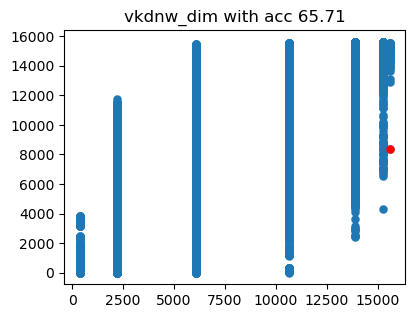

vkdnw_chisquare
|none~0|+|none~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=3341
cifar10-valid  FLOP= 19.58 M, Params=0.157 MB, latency=18.19 ms.
cifar10-valid  train : [loss = 2.302 & top1 = 10.29%], valid : [loss = 2.303 & top1 = 9.71%]
cifar10        FLOP= 19.58 M, Params=0.157 MB, latency=18.19 ms.
cifar10        train : [loss = 2.303 & top1 = 9.97%], test  : [loss = 2.303 & top1 = 10.00%]
cifar100       FLOP= 19.59 M, Params=0.163 MB, latency=17.08 ms.
cifar100       train : [loss = 4.605 & top1 = 1.00%], valid : [loss = 4.605 & top1 = 1.00%], test : [loss = 4.605 & top1 = 1.00%]
ImageNet16-120 FLOP=  4.90 M, Params=0.164 MB, latency=14.24 ms.
ImageNet16-120 train : [loss = 4.783 & top1 = 0.86%], valid : [loss = 4.792 & top1 = 0.83%], test : [loss = 4.792 & top1 = 0.83%]
vkdnw_chisquare: 0.01971807941133725	0.02884721834875816	0.02884721834875816	


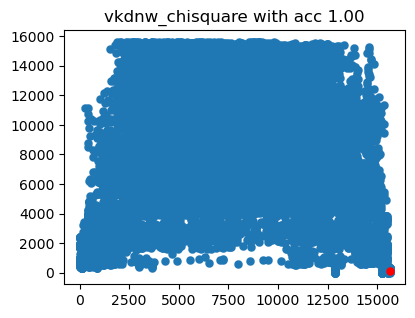

expressivity
progressivity
trainability
|nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=571
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.88 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.99%], valid : [loss = 0.493 & top1 = 90.14%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=20.88 ms.
cifar10        train : [loss = 0.003 & top1 = 99.97%], test  : [loss = 0.299 & top1 = 93.69%]
cifar100       FLOP=153.28 M, Params=1.079 MB, latency=19.39 ms.
cifar100       train : [loss = 0.042 & top1 = 99.54%], valid : [loss = 1.316 & top1 = 70.87%], test : [loss = 1.320 & top1 = 70.95%]
ImageNet16-120 FLOP= 38.33 M, Params=1.081 MB, latency=19.26 ms.
ImageNet16-120 train : [loss = 1.547 & top1 = 58.21%], valid : [loss = 2.186 & top1 = 44.64%], test : [loss = 2.152 & top1 = 45.33%]
trainability: 0.7232399731229435	0.9001939694153549

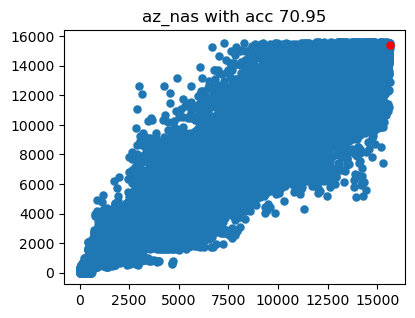

jacov
|nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=649
cifar10-valid  FLOP= 27.44 M, Params=0.213 MB, latency=21.01 ms.
cifar10-valid  train : [loss = 0.015 & top1 = 99.63%], valid : [loss = 0.572 & top1 = 87.36%]
cifar10        FLOP= 27.44 M, Params=0.213 MB, latency=21.01 ms.
cifar10        train : [loss = 0.033 & top1 = 99.05%], test  : [loss = 0.374 & top1 = 90.60%]
cifar100       FLOP= 27.45 M, Params=0.219 MB, latency=22.44 ms.
cifar100       train : [loss = 0.380 & top1 = 89.34%], valid : [loss = 1.264 & top1 = 67.45%], test : [loss = 1.272 & top1 = 67.13%]
ImageNet16-120 FLOP=  6.87 M, Params=0.220 MB, latency=20.33 ms.
ImageNet16-120 train : [loss = 2.110 & top1 = 45.12%], valid : [loss = 2.362 & top1 = 40.02%], test : [loss = 2.383 & top1 = 39.82%]
jacov: 0.554054686070444	0.7202800732620127	0.7202800732620127	


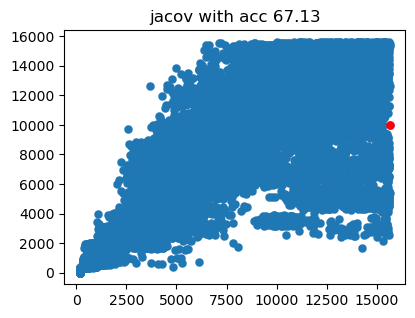

gradsign
|avg_pool_3x3~0|+|none~0|avg_pool_3x3~1|+|avg_pool_3x3~0|skip_connect~1|avg_pool_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=893
cifar10-valid  FLOP=  7.78 M, Params=0.073 MB, latency=9.95 ms.
cifar10-valid  train : [loss = 1.278 & top1 = 54.00%], valid : [loss = 1.322 & top1 = 52.71%]
cifar10        FLOP=  7.78 M, Params=0.073 MB, latency=9.95 ms.
cifar10        train : [loss = 1.286 & top1 = 53.90%], test  : [loss = 1.290 & top1 = 53.90%]
cifar100       FLOP=  7.79 M, Params=0.079 MB, latency=9.57 ms.
cifar100       train : [loss = 2.800 & top1 = 30.20%], valid : [loss = 2.902 & top1 = 28.57%], test : [loss = 2.890 & top1 = 28.69%]
ImageNet16-120 FLOP=  1.95 M, Params=0.080 MB, latency=8.66 ms.
ImageNet16-120 train : [loss = 3.934 & top1 = 11.38%], valid : [loss = 3.936 & top1 = 11.80%], test : [loss = 3.955 & top1 = 10.96%]
gradsign: -0.24043352051219652	-0.31482874676296035	-0.3148287467629604	


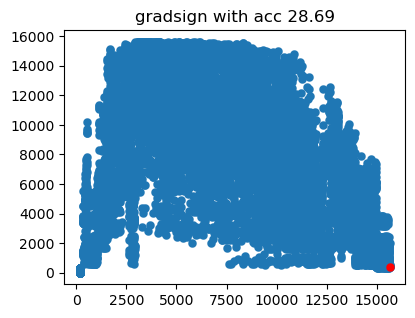

zico
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=1462
cifar10-valid  FLOP=220.12 M, Params=1.532 MB, latency=23.63 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.491 & top1 = 90.20%]
cifar10        FLOP=220.12 M, Params=1.532 MB, latency=23.63 ms.
cifar10        train : [loss = 0.002 & top1 = 99.97%], test  : [loss = 0.296 & top1 = 93.76%]
cifar100       FLOP=220.13 M, Params=1.537 MB, latency=22.58 ms.
cifar100       train : [loss = 0.024 & top1 = 99.79%], valid : [loss = 1.365 & top1 = 70.71%], test : [loss = 1.354 & top1 = 71.11%]
ImageNet16-120 FLOP= 55.04 M, Params=1.539 MB, latency=22.16 ms.
ImageNet16-120 train : [loss = 1.863 & top1 = 50.60%], valid : [loss = 2.316 & top1 = 40.78%], test : [loss = 2.311 & top1 = 41.44%]
zico: 0.6003262702370438	0.7945654041237131	0.7945654041237132	


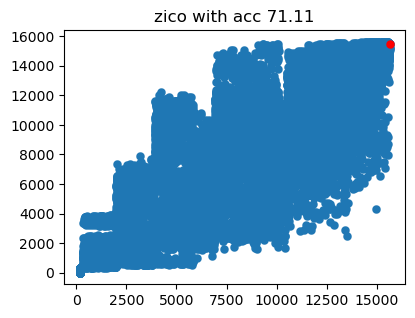

zen
|skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|skip_connect~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=10319
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=15.94 ms.
cifar10-valid  train : [loss = 0.035 & top1 = 99.37%], valid : [loss = 0.486 & top1 = 87.34%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=15.94 ms.
cifar10        train : [loss = 0.042 & top1 = 98.77%], test  : [loss = 0.368 & top1 = 90.65%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=15.42 ms.
cifar100       train : [loss = 0.494 & top1 = 85.75%], valid : [loss = 1.211 & top1 = 67.20%], test : [loss = 1.196 & top1 = 68.10%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=12.93 ms.
ImageNet16-120 train : [loss = 2.132 & top1 = 44.57%], valid : [loss = 2.332 & top1 = 39.62%], test : [loss = 2.359 & top1 = 40.77%]
zen: 0.231834206624401	0.30000239968671566	0.3000023996867157	


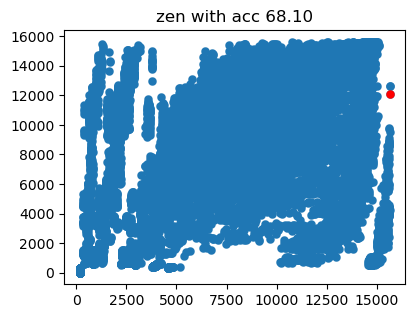

grad_norm
|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=818
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=17.96 ms.
cifar10-valid  train : [loss = 0.084 & top1 = 97.37%], valid : [loss = 0.610 & top1 = 84.39%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=17.96 ms.
cifar10        train : [loss = 0.097 & top1 = 96.80%], test  : [loss = 0.420 & top1 = 88.52%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=17.80 ms.
cifar100       train : [loss = 0.731 & top1 = 78.82%], valid : [loss = 1.528 & top1 = 59.88%], test : [loss = 1.523 & top1 = 60.02%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=16.56 ms.
ImageNet16-120 train : [loss = 4.334 & top1 = 5.39%], valid : [loss = 4.309 & top1 = 5.73%], test : [loss = 4.319 & top1 = 5.46%]
grad_norm: 0.3587098820147263	0.48943947563642753	0.4894394756364274	


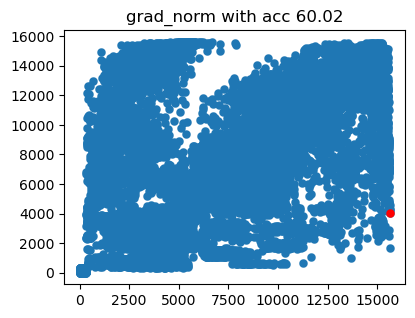

naswot
|nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4317
cifar10-valid  FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10-valid  train : [loss = 0.072 & top1 = 98.13%], valid : [loss = 0.470 & top1 = 86.51%]
cifar10        FLOP= 31.38 M, Params=0.241 MB, latency=22.64 ms.
cifar10        train : [loss = 0.098 & top1 = 97.07%], test  : [loss = 0.340 & top1 = 89.37%]
cifar100       FLOP= 31.38 M, Params=0.247 MB, latency=21.61 ms.
cifar100       train : [loss = 0.586 & top1 = 84.28%], valid : [loss = 1.258 & top1 = 65.40%], test : [loss = 1.274 & top1 = 65.71%]
ImageNet16-120 FLOP=  7.85 M, Params=0.248 MB, latency=21.04 ms.
ImageNet16-120 train : [loss = 2.440 & top1 = 38.04%], valid : [loss = 2.561 & top1 = 35.32%], test : [loss = 2.569 & top1 = 35.48%]
naswot: 0.5789540756470848	0.7681574559900084	0.7681574559900083	


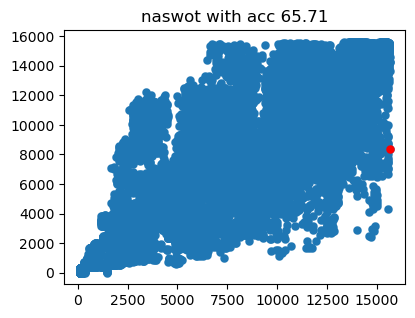

synflow
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=9930
cifar10-valid  FLOP=184.73 M, Params=1.289 MB, latency=20.59 ms.
cifar10-valid  train : [loss = 0.001 & top1 = 99.99%], valid : [loss = 0.424 & top1 = 91.55%]
cifar10        FLOP=184.73 M, Params=1.289 MB, latency=20.59 ms.
cifar10        train : [loss = 0.002 & top1 = 99.99%], test  : [loss = 0.278 & top1 = 94.36%]
cifar100       FLOP=184.74 M, Params=1.294 MB, latency=19.92 ms.
cifar100       train : [loss = 0.013 & top1 = 99.94%], valid : [loss = 1.259 & top1 = 73.49%], test : [loss = 1.237 & top1 = 73.51%]
ImageNet16-120 FLOP= 46.19 M, Params=1.296 MB, latency=20.57 ms.
ImageNet16-120 train : [loss = 0.952 & top1 = 73.23%], valid : [loss = 2.277 & top1 = 46.37%], test : [loss = 2.303 & top1 = 46.34%]
synflow: 0.5647696009241224	0.7612260499672334	0.7612260499672334	


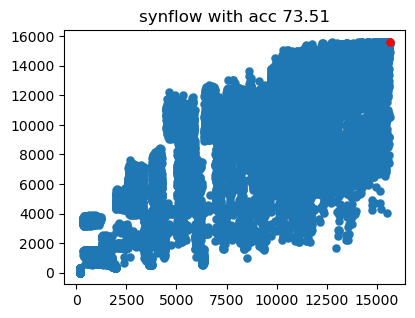

snip
|nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|none~0|none~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=5220
cifar10-valid  FLOP= 51.04 M, Params=0.372 MB, latency=17.85 ms.
cifar10-valid  train : [loss = 0.070 & top1 = 97.76%], valid : [loss = 0.578 & top1 = 85.67%]
cifar10        FLOP= 51.04 M, Params=0.372 MB, latency=17.85 ms.
cifar10        train : [loss = 0.082 & top1 = 97.29%], test  : [loss = 0.392 & top1 = 89.27%]
cifar100       FLOP= 51.04 M, Params=0.378 MB, latency=17.14 ms.
cifar100       train : [loss = 0.765 & top1 = 77.76%], valid : [loss = 1.445 & top1 = 61.29%], test : [loss = 1.434 & top1 = 61.82%]
ImageNet16-120 FLOP= 12.77 M, Params=0.379 MB, latency=16.13 ms.
ImageNet16-120 train : [loss = 2.931 & top1 = 26.70%], valid : [loss = 2.924 & top1 = 26.83%], test : [loss = 2.973 & top1 = 25.92%]
snip: 0.461477145174001	0.6196734638663612	0.6196734638663611	


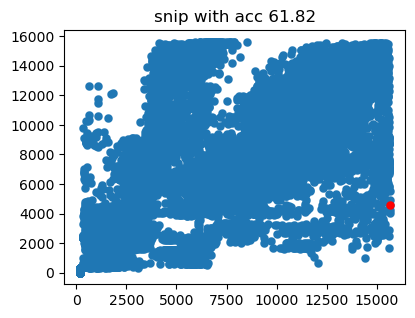

grasp
|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=13906
cifar10-valid  FLOP= 82.49 M, Params=0.587 MB, latency=18.58 ms.
cifar10-valid  train : [loss = 0.074 & top1 = 97.58%], valid : [loss = 0.594 & top1 = 85.17%]
cifar10        FLOP= 82.49 M, Params=0.587 MB, latency=18.58 ms.
cifar10        train : [loss = 0.059 & top1 = 98.10%], test  : [loss = 0.406 & top1 = 89.48%]
cifar100       FLOP= 82.50 M, Params=0.593 MB, latency=17.42 ms.
cifar100       train : [loss = 0.617 & top1 = 82.22%], valid : [loss = 1.468 & top1 = 61.82%], test : [loss = 1.447 & top1 = 62.01%]
ImageNet16-120 FLOP= 20.63 M, Params=0.595 MB, latency=17.78 ms.
ImageNet16-120 train : [loss = 3.222 & top1 = 21.41%], valid : [loss = 3.236 & top1 = 20.99%], test : [loss = 3.240 & top1 = 20.56%]
grasp: 0.32180280780166987	0.4620117637639668	0.46201176376396674	


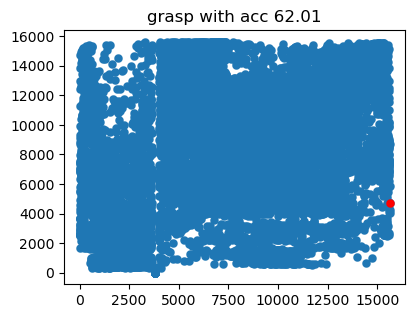

ntk
linear_region
|avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|none~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=9462
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=16.58 ms.
cifar10-valid  train : [loss = 0.007 & top1 = 99.90%], valid : [loss = 0.513 & top1 = 88.79%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=16.58 ms.
cifar10        train : [loss = 0.012 & top1 = 99.76%], test  : [loss = 0.336 & top1 = 92.11%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=18.94 ms.
cifar100       train : [loss = 0.340 & top1 = 90.66%], valid : [loss = 1.267 & top1 = 67.15%], test : [loss = 1.293 & top1 = 67.04%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=15.57 ms.
ImageNet16-120 train : [loss = 2.128 & top1 = 44.65%], valid : [loss = 2.415 & top1 = 38.92%], test : [loss = 2.416 & top1 = 39.32%]
linear_region: 0.4816580038673179	0.665302789229127	0.6653027892291271	


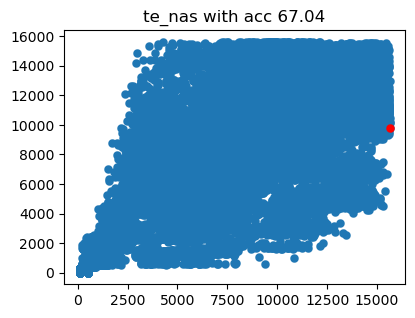

In [78]:
for zero_cost_score in zero_cost_score_list:
    results_temp = results.loc[results['seed'] == results['seed'].unique().min(), :].copy()
    analyze_results(api_nats, results_temp, zero_cost_score, target)

In [79]:
log_train = None
if not compute_graf:
    print('No graf prediction.')
else:
    print('Graf prediction.')
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    
    pred_lists = {
        'model_vkdnw': [p for p in results.columns if '_lambda_' in p] + ['vkdnw_chisquare', 'vkdnw_dim', 'flops'],
        'model_vkdnw+zs': [p for p in results.columns if '_lambda_' in p] + ['vkdnw_chisquare', 'vkdnw_dim', 'flops'] + ['expressivity', 'progressivity', 'trainability', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'ntk', 'linear_region'],
        'model_vkdnw+zs+graf': [p for p in results.columns if '_lambda_' in p] + ['vkdnw_chisquare', 'vkdnw_dim', 'flops'] + ['expressivity', 'progressivity', 'trainability', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'ntk', 'linear_region'] + [p for p in results.columns if 'op_' in p] + [p for p in results.columns if 'node_' in p]
    }
    
    for train_size in [32, 128, 1024]:
        for seed in results['seed'].unique():
            
            results_temp = results.loc[results['seed'] == seed, :].copy()
            results_temp = results_temp.apply(lambda x: x.replace(-np.inf, x[x != -np.inf].min()))
            results_temp = results_temp.apply(lambda x: x.replace(np.inf, x[x != np.inf].max()))
            for model_name, pred_list in pred_lists.items():
                
                train_df, test_df = train_test_split(results_temp, test_size=1 - (train_size / results_temp.shape[0]), random_state=seed)
                model = Pipeline([
                    ('scaler', StandardScaler()),           # Step 1: Standardize features
                    ('regressor', RandomForestRegressor(n_estimators=300))  # Step 2: Train RandomForestRegressor
                ])
                model.fit(train_df[pred_list], train_df[target])
                test_df['pred_' + model_name] = model.predict(test_df[pred_list])
                log_train_temp = pd.DataFrame(get_metrics(test_df, 'pred_' + model_name, show_plot=False))        
                log_train_temp['train_size'] = train_size
            
                if log_train is None:
                    log_train = log_train_temp.copy()
                else:
                    log_train = pd.concat([log_train, log_train_temp.copy()], ignore_index=True)
                    
                if seed == min(results['seed'].unique()):
                    plot_stats(get_stats(test_df, 'vkdnw_dim', target, 'pred_' + model_name), 'vkdnw_dim', target, model_name, f'{dataset}_{str(compute_graf)}_{model_name}_{train_size}')

    log_train = log_train.groupby(['pred_name', 'train_size'], as_index=False).agg(['mean', 'std']).reset_index()
    log_train['dataset'] = dataset
    log_train['no_seeds'] = len(results['seed'].unique())
    log_train['archs_filtered'] = str(compute_graf)
    log_train

No graf prediction.


In [80]:
if compute_graf:
    name_app = 'filtered'
    log_save = pd.concat([log, log_train], ignore_index=True)
else:
    name_app = 'unfiltered'
    log_save = log

log_save.to_csv(f'{dataset}_{name_app}_log.csv', index=False)

In [81]:
log_save[['pred_name', 'kendall']]

pred_name   kendall          
                              mean       std
0            az_nas_rank  0.722913  0.000735
1         grad_norm_rank  0.358166  0.000568
2          gradsign_rank -0.240245  0.000536
3             grasp_rank  0.321409  0.003612
4             jacov_rank  0.554356  0.001063
5            naswot_rank  0.578942  0.000108
6              snip_rank  0.461286  0.000273
7           synflow_rank  0.564794  0.000248
8            te_nas_rank  0.481388  0.001266
9   vkdnw_chisquare_rank  0.016806  0.003247
10       vkdnw_comb_rank  0.732095  0.000481
11        vkdnw_dim_rank  0.594197  0.000000
12        vkdnw_exp_rank  0.692471  0.001049
13       vkdnw_prog_rank  0.711067  0.000627
14            vkdnw_rank  0.530623  0.000598
15      vkdnw_train_rank  0.688582  0.000704
16              zen_rank  0.231769  0.000120
17             zico_rank  0.600222  0.000513

# Fisher matrix size

- how does metrics evolve with changing params_grad_len
- data: ImageNet16-120 with batch size 32
- wandb runs: ImageNet16-120_B32_params_grad_len_X

In [4]:
# Import accs
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)
accs = generate_accs(api_nats, dataset='ImageNet16-120')

In [5]:
# Import data
api_wandb = wandb.Api()

results = None
for run_id, params_grad_len in {
    'nazderaze/VKDNW/hqc53sey': 8,
    'nazderaze/VKDNW/kkyfzf21': 16,
    'nazderaze/VKDNW/3bzcrn0t': 32, # compute time 45m 21s
    'nazderaze/VKDNW/3oj5wxoe': 64, # compute time 52m 39s
    'nazderaze/VKDNW/m29ccmi0': 128, # compute time 56m 57s
    'nazderaze/VKDNW/y9ib6om2': 256, # compute time 1h 3m 7s
}.items():
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run['params_grad_len'] = params_grad_len
    run = pd.merge(accs, run, on='arch', how='inner')
    print(f'Fisher matrix size: {params_grad_len}. No. of archs after filtering {run.shape[0]}.')
    
    if results is None:
        results = run
    else:
        results = pd.concat([results, run], ignore_index=True)

Fisher matrix size: 8. No. of archs after filtering 9445.
Fisher matrix size: 16. No. of archs after filtering 9445.
Fisher matrix size: 32. No. of archs after filtering 9445.
Fisher matrix size: 64. No. of archs after filtering 9445.
Fisher matrix size: 128. No. of archs after filtering 9445.
Fisher matrix size: 256. No. of archs after filtering 9445.


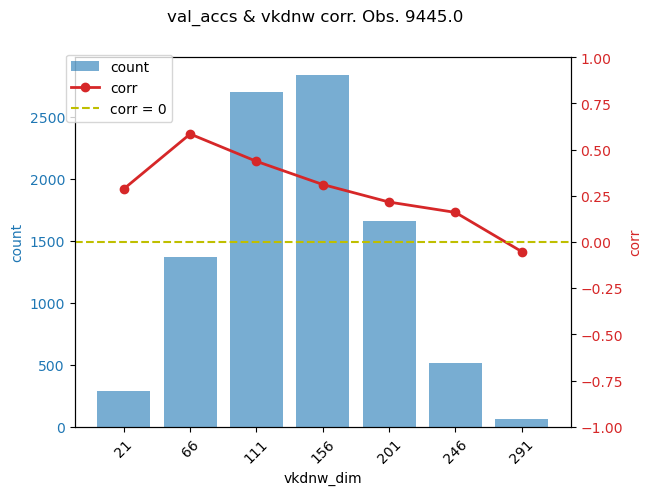

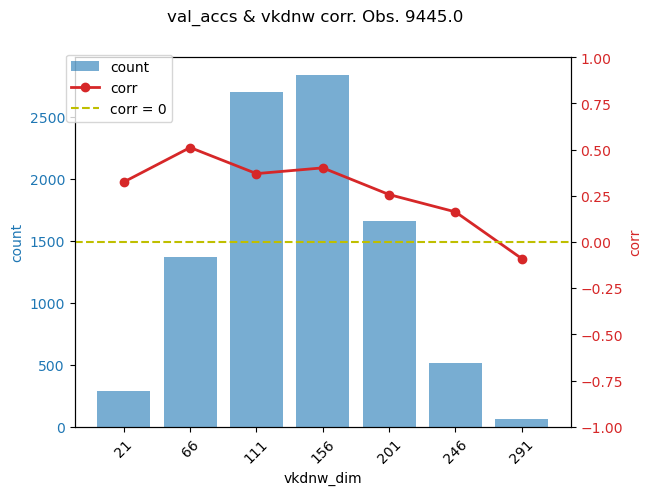

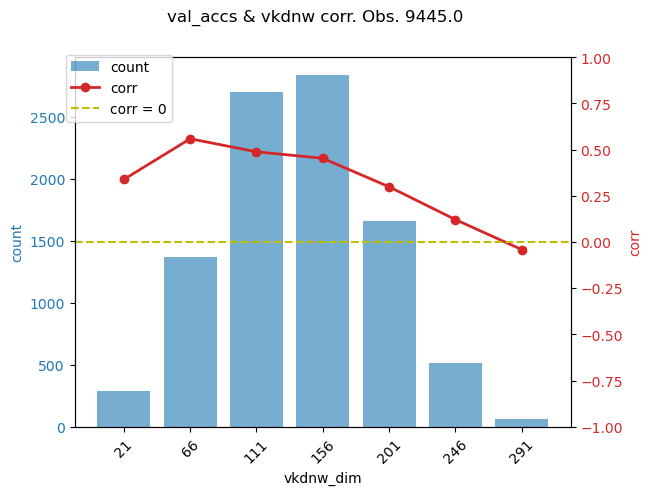

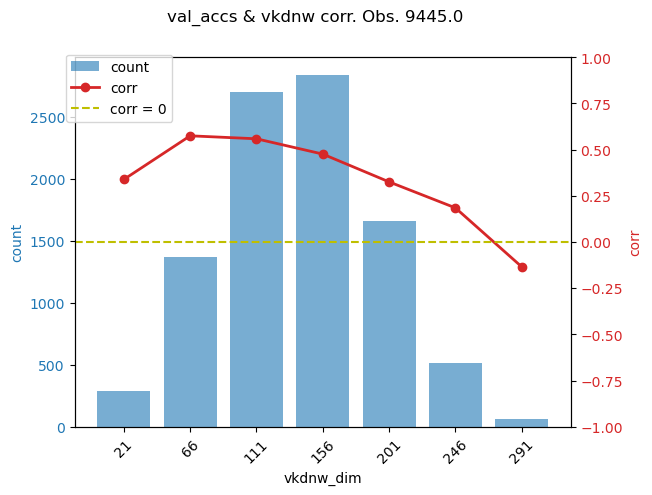

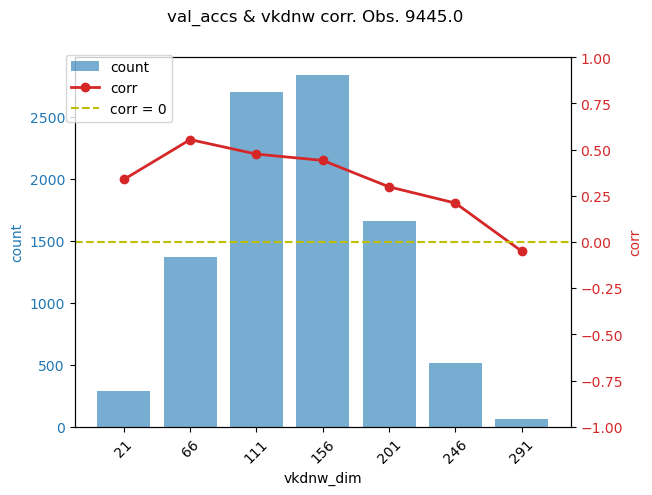

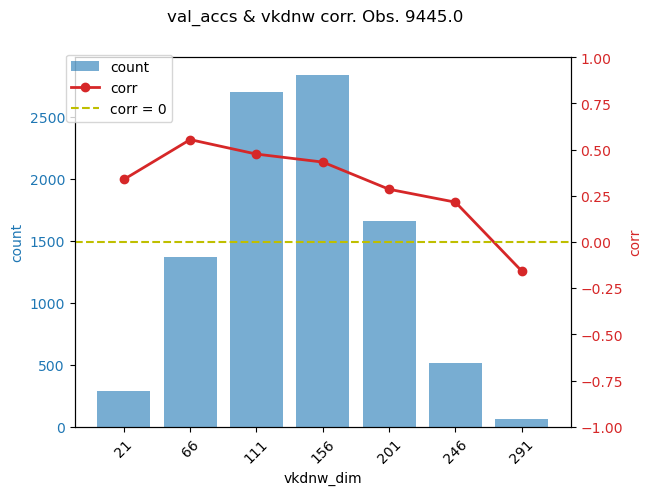

In [6]:
log = None
for params_grad_len in [8, 16, 32, 64, 128, 256]:
    results_temp = results.loc[results['params_grad_len']==params_grad_len].copy()
    results_temp['vkdnw'] = compute_vkdnw(results_temp)
    plot_stats(get_stats(results_temp, 'vkdnw_dim', target, 'vkdnw'), 'vkdnw_dim', target, 'vkdnw')
    log_temp = pd.DataFrame(get_metrics(results_temp, 'vkdnw', show_plot=False))
    log_temp['params_grad_len'] = params_grad_len
    
    if log is None:
        log = log_temp
    else:
        log = pd.concat([log, log_temp], ignore_index=True)

In [7]:
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,params_grad_len
0,vkdnw,0.630941,0.814720,0.742376,0.574150,0.406820,0.043423,0.928104,0.424796,0.443023,8
1,vkdnw,0.633412,0.818724,0.745830,0.574304,0.407154,0.043435,0.932731,0.437110,0.440193,16
2,vkdnw,0.649957,0.832984,0.756925,0.575469,0.407854,0.043451,0.937561,0.437972,0.441665,32
3,vkdnw,0.659148,0.839057,0.756658,0.575870,0.408206,0.043530,0.934535,0.444159,0.439626,64
4,vkdnw,0.648114,0.830015,0.739769,0.575000,0.407730,0.043550,0.941453,0.450301,0.446952,128
5,vkdnw,0.646909,0.828585,0.738657,0.574895,0.407557,0.043532,0.934713,0.437676,0.440637,256


Fisher matrix size: 8
vkdnw
|nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12117
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.68 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.517 & top1 = 89.90%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.68 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.310 & top1 = 93.31%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.02 ms.
cifar100       train : [loss = 0.059 & top1 = 99.19%], valid : [loss = 1.296 & top1 = 70.52%], test : [loss = 1.322 & top1 = 70.31%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=22.20 ms.
ImageNet16-120 train : [loss = 1.849 & top1 = 51.01%], valid : [loss = 2.258 & top1 = 42.33%], test : [loss = 2.274 & top1 = 42.03%]
vkdnw: 0.6309414339548626	0.814719826424962	0.814719826424961

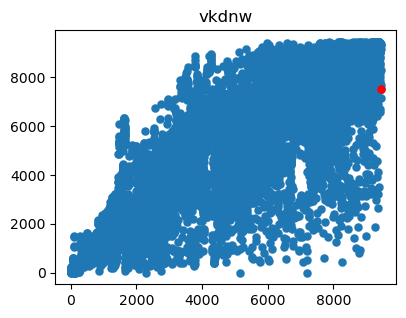

Fisher matrix size: 16
vkdnw
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4681
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.35 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.477 & top1 = 90.20%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.35 ms.
cifar10        train : [loss = 0.003 & top1 = 99.96%], test  : [loss = 0.294 & top1 = 93.61%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.45 ms.
cifar100       train : [loss = 0.063 & top1 = 99.15%], valid : [loss = 1.320 & top1 = 69.75%], test : [loss = 1.332 & top1 = 69.82%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=22.26 ms.
ImageNet16-120 train : [loss = 1.634 & top1 = 56.07%], valid : [loss = 2.155 & top1 = 44.11%], test : [loss = 2.145 & top1 = 45.27%]
vkdnw: 0.6334122048573143	0.818723613571873	0.818723613571873

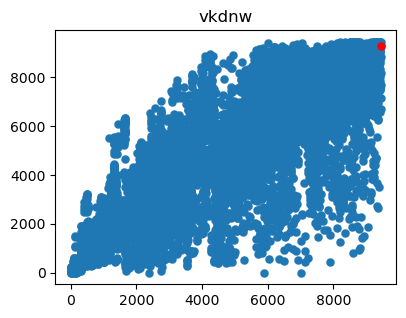

Fisher matrix size: 32
vkdnw
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7294
cifar10-valid  FLOP=157.21 M, Params=1.101 MB, latency=23.10 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.508 & top1 = 89.98%]
cifar10        FLOP=157.21 M, Params=1.101 MB, latency=23.10 ms.
cifar10        train : [loss = 0.003 & top1 = 99.97%], test  : [loss = 0.308 & top1 = 93.42%]
cifar100       FLOP=157.21 M, Params=1.107 MB, latency=23.04 ms.
cifar100       train : [loss = 0.037 & top1 = 99.62%], valid : [loss = 1.320 & top1 = 71.02%], test : [loss = 1.336 & top1 = 71.03%]
ImageNet16-120 FLOP= 39.31 M, Params=1.109 MB, latency=19.37 ms.
ImageNet16-120 train : [loss = 1.857 & top1 = 50.71%], valid : [loss = 2.292 & top1 = 41.10%], test : [loss = 2.292 & top1 = 42.22%]
vkdnw: 0.6499571265397174	0.8329839250376998	0.8329839250377	

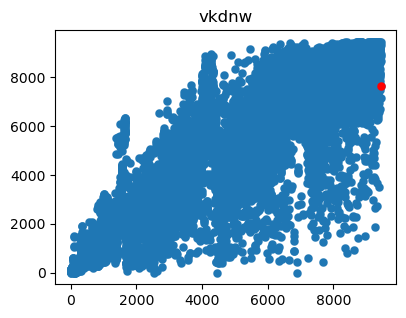

Fisher matrix size: 64
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7442
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.12 ms.
cifar10-valid  train : [loss = 0.003 & top1 = 99.97%], valid : [loss = 0.492 & top1 = 89.85%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.12 ms.
cifar10        train : [loss = 0.004 & top1 = 99.94%], test  : [loss = 0.305 & top1 = 93.10%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.38 ms.
cifar100       train : [loss = 0.080 & top1 = 98.81%], valid : [loss = 1.276 & top1 = 70.38%], test : [loss = 1.290 & top1 = 70.34%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=21.80 ms.
ImageNet16-120 train : [loss = 1.597 & top1 = 56.99%], valid : [loss = 2.159 & top1 = 44.28%], test : [loss = 2.167 & top1 = 45.24%]
vkdnw: 0.6591479349612106	0.8390568795013581	0.83905687950135

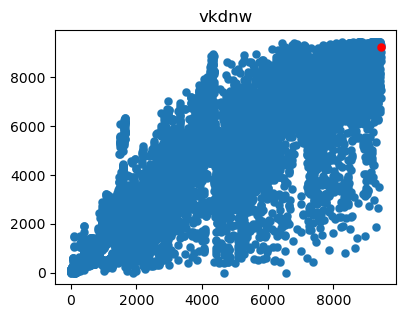

Fisher matrix size: 128
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12598
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.487 & top1 = 90.30%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10        train : [loss = 0.004 & top1 = 99.93%], test  : [loss = 0.308 & top1 = 93.32%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=19.63 ms.
cifar100       train : [loss = 0.071 & top1 = 99.00%], valid : [loss = 1.307 & top1 = 70.32%], test : [loss = 1.317 & top1 = 70.02%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=18.13 ms.
ImageNet16-120 train : [loss = 1.550 & top1 = 58.07%], valid : [loss = 2.128 & top1 = 45.32%], test : [loss = 2.163 & top1 = 44.95%]
vkdnw: 0.6481142262918091	0.830015164089027	0.8300151640890

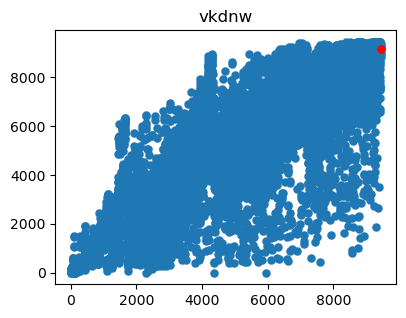

Fisher matrix size: 256
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12598
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.487 & top1 = 90.30%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10        train : [loss = 0.004 & top1 = 99.93%], test  : [loss = 0.308 & top1 = 93.32%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=19.63 ms.
cifar100       train : [loss = 0.071 & top1 = 99.00%], valid : [loss = 1.307 & top1 = 70.32%], test : [loss = 1.317 & top1 = 70.02%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=18.13 ms.
ImageNet16-120 train : [loss = 1.550 & top1 = 58.07%], valid : [loss = 2.128 & top1 = 45.32%], test : [loss = 2.163 & top1 = 44.95%]
vkdnw: 0.6469087665593058	0.828585268188039	0.8285852681880

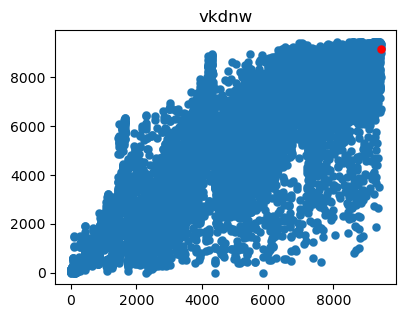

In [8]:
for params_grad_len in [8, 16, 32, 64, 128, 256]:
    results_temp = results.loc[results['params_grad_len']==params_grad_len].copy()
    print(f'Fisher matrix size: {params_grad_len}')
    analyze_results(api_nats, results_temp, 'vkdnw', target)

# Batch size

- how does metrics evolve with changing batch_size
- data: cifar10 with batch size 32 and real input whenever possible
- wandb runs: cifar10_BX_real_input

In [2]:
# Import accs
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)
accs = generate_accs(api_nats, dataset='ImageNet16-120', filter=False)
accs

StopIteration: 

StopIteration: 

In [42]:
import pickle
with open("./tss_all_arch.pickle", "rb") as fp:
    all_archs = pickle.load(fp)
        
api_valid_accs, api_flops, api_params = [], [], []
for a in all_archs:
    try:
        valid_acc, flops, params = get_results_from_api(api_nats, a, 'ImageNet16-120')
        api_valid_accs.append(valid_acc)
        api_flops.append(flops)
        api_params.append(params)
    except Exception as e:
        print(e)
        
accs = pd.DataFrame({
    'arch': [a.tostr() for a in all_archs],
    'val_accs': api_valid_accs,
    'flops': api_flops,
    'params': api_params,
})

In [77]:
# Import data
api_wandb = wandb.Api()

results = None
for run_id, batch_size in {
    #'nazderaze/VKDNW/9d14s94e': 16,
    #'nazderaze/VKDNW/cmic3xuh': 32,
    #'nazderaze/VKDNW/giukshg3': 64,
    #'nazderaze/VKDNW/gvzf6mwl': 128,
    'nazderaze/VKDNW/v8buuof4': 32 #imagenet rand
    #'nazderaze/VKDNW/kwuhsrer': 32 # imagtnet real
}.items():
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run['batch_size'] = batch_size
    run = pd.merge(accs, run, on='arch', how='left')
    print(f'Batch size: {batch_size}. No. of archs after filtering {run.shape[0]}.')
    
    if results is None:
        results = run
    else:
        results = pd.concat([results, run], ignore_index=True)

Batch size: 32. No. of archs after filtering 15625.


In [78]:
for col in results.columns:
    if col != 'arch':
        results[col] = results[col].astype(float)

In [79]:
results.loc[results['jacov'].isnull(), 'jacov'] = results['jacov'].min()

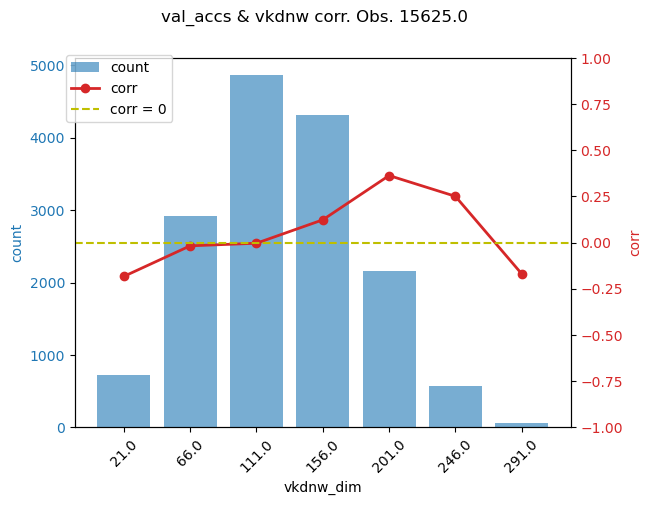

In [80]:
log = None
for batch_size in results['batch_size'].unique():
    results_temp = results.loc[results['batch_size']==batch_size].copy()
    
    results_temp['vkdnw'] = compute_vkdnw(results_temp)
    plot_stats(get_stats(results_temp, 'vkdnw_dim', target, 'vkdnw'), 'vkdnw_dim', target, 'vkdnw')
    log_vkdnw = pd.DataFrame(get_metrics(results_temp, 'vkdnw', show_plot=False))
    log_vkdnw['batch_size'] = batch_size
    
    results_temp['vkdnw_flops'] = results_temp['vkdnw'].rank().apply(np.log) * results_temp['flops'].rank().apply(np.log)
    log_flops = pd.DataFrame(get_metrics(results_temp, 'vkdnw_flops', show_plot=False))
    log_flops['batch_size'] = batch_size
    
    results_temp['vkdnw_exp'] =  results_temp['vkdnw'].rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_exp = pd.DataFrame(get_metrics(results_temp, 'vkdnw_exp', show_plot=False))
    log_exp['batch_size'] = batch_size
    
    results_temp['vkdnw_prog'] =  results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['vkdnw'].rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_prog = pd.DataFrame(get_metrics(results_temp, 'vkdnw_prog', show_plot=False))
    log_prog['batch_size'] = batch_size
    
    results_temp['vkdnw_trai'] =  results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['vkdnw'].rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)    
    log_trai = pd.DataFrame(get_metrics(results_temp, 'vkdnw_trai', show_plot=False))
    log_trai['batch_size'] = batch_size
    
    results_temp['az_nas'] = results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_az = pd.DataFrame(get_metrics(results_temp, 'az_nas', show_plot=False))
    log_az['batch_size'] = batch_size
    
    if log is None:
        log = pd.concat([log_vkdnw, log_flops, log_exp, log_prog, log_trai, log_az], ignore_index=True)
    else:
        log = pd.concat([log, log_vkdnw, log_flops, log_exp, log_prog, log_trai, log_az], ignore_index=True)
        
    for pred_name in ['gradsign', 'zico', 'zen','naswot','synflow','snip','grasp', 'zen', 'jacov']:
        results_temp[pred_name] = results_temp[pred_name].astype(float).rank()
        log_temp = pd.DataFrame(get_metrics(results_temp, pred_name, show_plot=False))
        log_temp['batch_size'] = batch_size
        log = pd.concat([log, log_temp], ignore_index=True)

In [81]:
# IN rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.519499,0.708751,0.623443,0.579266,0.391545,0.043254,0.931568,0.435225,0.436227,32.0
1,vkdnw_flops,0.541603,0.734992,0.679512,0.580549,0.391090,0.042643,0.912855,0.415094,0.431138,32.0
2,vkdnw_exp,0.667432,0.859745,0.845288,0.597910,0.400512,0.043717,0.954597,0.440412,0.447207,32.0
3,vkdnw_prog,0.679080,0.867631,0.845046,0.598112,0.400932,0.043724,0.950947,0.439465,0.445697,32.0
4,vkdnw_trai,0.630195,0.818701,0.814508,0.592500,0.395378,0.042155,0.906371,0.410229,0.421871,32.0
5,az_nas,0.671773,0.858802,0.874021,0.598280,0.399595,0.043268,0.947654,0.443887,0.439196,32.0
6,gradsign,-0.173231,-0.228196,-0.108086,0.486695,0.310728,0.022074,0.342155,0.161128,0.161139,32.0
7,zico,0.602476,0.793496,0.750188,0.592347,0.396218,0.042855,0.919770,0.426090,0.427395,32.0
8,zen,0.260149,0.358017,0.396907,0.548859,0.354905,0.031651,0.784693,0.398590,0.346656,32.0
9,naswot,0.611091,0.792200,0.752459,0.592627,0.395713,0.042646,0.926666,0.396220,0.447590,32.0


In [76]:
# IN real
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.515595,0.706100,0.636677,0.578943,0.391376,0.043260,0.931105,0.429002,0.439398,32.0
1,vkdnw_flops,0.540000,0.734071,0.677375,0.580396,0.391063,0.042644,0.916300,0.423507,0.423254,32.0
2,vkdnw_exp,0.610242,0.807044,0.815197,0.593805,0.397027,0.043350,0.947305,0.436001,0.447023,32.0
3,vkdnw_prog,0.660864,0.852287,0.821171,0.596385,0.400014,0.043728,0.947962,0.435771,0.443246,32.0
4,vkdnw_trai,0.556295,0.748022,0.760586,0.586181,0.391491,0.042257,0.919092,0.418304,0.441849,32.0
5,az_nas,0.607677,0.803046,0.835856,0.593955,0.396114,0.042911,0.940787,0.433633,0.441923,32.0
6,gradsign,-0.177431,-0.232116,-0.111808,0.486236,0.309664,0.021206,0.313275,0.146142,0.153826,32.0
7,zico,0.599894,0.792333,0.748645,0.592158,0.396177,0.042872,0.918095,0.425116,0.432898,32.0
8,zen,0.226680,0.316603,0.369193,0.545447,0.352188,0.031487,0.799081,0.393779,0.381852,32.0
9,naswot,0.593334,0.776978,0.737279,0.590759,0.394664,0.042646,0.927265,0.400891,0.446908,32.0


In [45]:
# IN rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.519499,0.708751,0.623443,0.579266,0.391545,0.043254,0.931568,0.435225,0.436227,32
1,vkdnw_flops,0.541603,0.734992,0.679512,0.580549,0.391090,0.042643,0.912855,0.415094,0.431138,32
2,vkdnw_exp,0.667432,0.859745,0.845288,0.597910,0.400512,0.043717,0.954597,0.440412,0.447207,32
3,vkdnw_prog,0.679080,0.867631,0.845046,0.598112,0.400932,0.043724,0.950947,0.439465,0.445697,32
4,vkdnw_trai,0.630195,0.818701,0.814508,0.592500,0.395378,0.042155,0.906371,0.410229,0.421871,32
5,az_nas,0.671773,0.858802,0.874021,0.598280,0.399595,0.043268,0.947654,0.443887,0.439196,32


In [25]:
# real
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.611147,0.803146,0.758054,0.572503,0.406610,0.043460,0.931105,0.429002,0.439398,32
1,vkdnw_flops,0.615883,0.806525,0.824650,0.572486,0.405637,0.042880,0.916202,0.423446,0.423392,32
2,vkdnw_exp,0.620683,0.812089,0.859026,0.574967,0.407072,0.043798,0.950372,0.437601,0.444191,32
3,vkdnw_prog,0.695918,0.874842,0.884362,0.578658,0.410327,0.044066,0.944587,0.436931,0.445379,32
4,vkdnw_trai,0.580295,0.764877,0.808779,0.569467,0.403002,0.042934,0.922635,0.417245,0.437343,32
5,az_nas,0.592456,0.787018,0.822305,0.572652,0.405563,0.043557,0.941073,0.433381,0.441813,32


In [22]:
# rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.646908,0.828585,0.738657,0.574895,0.407554,0.043529,0.931568,0.435225,0.436227,32
1,vkdnw_flops,0.631451,0.816308,0.840885,0.573524,0.405936,0.042817,0.912855,0.415094,0.431138,32
2,vkdnw_exp,0.664144,0.851997,0.875792,0.577418,0.409307,0.044041,0.952766,0.438495,0.450524,32
3,vkdnw_prog,0.703325,0.879728,0.898475,0.579363,0.410573,0.044070,0.950808,0.439424,0.445860,32
4,vkdnw_trai,0.645956,0.825972,0.841372,0.573794,0.405503,0.042530,0.918109,0.411636,0.427104,32
5,az_nas,0.643782,0.835676,0.843053,0.575671,0.408022,0.043750,0.948355,0.443259,0.447419,32


Batch size: 32
expressivity
progressivity
trainability
|nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=6022
cifar10-valid  FLOP=121.82 M, Params=0.858 MB, latency=20.11 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.489 & top1 = 90.16%]
cifar10        FLOP=121.82 M, Params=0.858 MB, latency=20.11 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.301 & top1 = 93.60%]
cifar100       FLOP=121.82 M, Params=0.864 MB, latency=19.01 ms.
cifar100       train : [loss = 0.055 & top1 = 99.33%], valid : [loss = 1.296 & top1 = 70.46%], test : [loss = 1.286 & top1 = 70.77%]
ImageNet16-120 FLOP= 30.46 M, Params=0.866 MB, latency=20.66 ms.
ImageNet16-120 train : [loss = 1.619 & top1 = 56.44%], valid : [loss = 2.163 & top1 = 44.27%], test : [loss = 2.197 & top1 = 44.14%]
AZ-NAS: 0.671772514656878	0.8588018

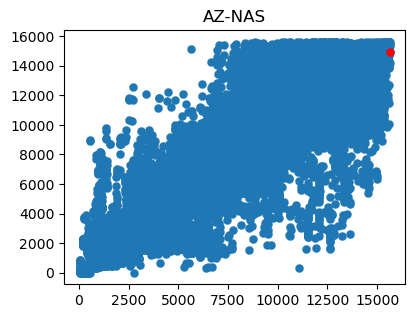

In [83]:
for batch_size in [32]:
    results_temp = results.loc[results['batch_size']==batch_size].copy()
    print(f'Batch size: {batch_size}')
    analyze_results(api_nats, results_temp, 'az_nas', target)

In [10]:
results_temp.head()

,arch,val_accs,flops,params,_timestamp,vkdnw_lambda_1,vkdnw_lambda_2,vkdnw_lambda_6,jacov,vkdnw_lambda_8,...,trainability,grasp,grad_norm,naswot,_runtime,vkdnw_lambda_3,zen,zico,vkdnw_lambda_5,batch_size
0,|avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_...,88.916667,15.64737,0.129306,1.729556e+09,2.627798e-05,8.005195e-05,43.356880,-16.928594,1401.476685,...,-0.155076,1.782674,3.093219,192.557599,48633.014337,0.080949,95.459938,343.456662,7.197623,16
1,|nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~...,93.580000,82.49409,0.587386,1.729552e+09,2.448007e-02,2.796511e+00,1304.875732,-16.112389,71318.585938,...,-0.113689,1.677209,2.473265,198.715157,44518.133664,29.594460,133.148972,544.400148,394.967560,16
2,|skip_connect~0|+|skip_connect~0|none~1|+|nor_...,92.395000,82.49409,0.587386,1.729521e+09,2.290318e-05,1.409506e-04,76.826996,-16.075762,2137.810303,...,-0.106033,5.473819,6.602708,199.223709,13911.850612,0.025663,96.07267,550.793540,19.118641,16
3,|avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_...,90.605000,23.51169,0.185306,1.729555e+09,6.216018e-04,2.108188e-03,13.995205,-16.576809,1570.360352,...,-0.088,54.726673,13.180796,204.200699,47310.691766,0.014016,72.628822,606.687192,1.998187,16
4,|nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|nor_...,92.465000,90.35841,0.643386,1.729531e+09,1.190710e-08,2.478346e-07,1.285074,-16.082071,40.755959,...,-0.146349,4088.751751,80.977608,207.504915,23849.235478,0.000002,103.321503,808.339716,0.283654,16
